COMP 215 - LAB 6 (Game of Life)
-----------------------------------------------
#### Name:
#### Date:

This lab exercise is an introduction to [Conway's Game of Life](https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life) discovered and studied by [John Conway](https://en.wikipedia.org/wiki/John_Horton_Conway).

**New Python concepts**:
   * 2D numpy [array](https://numpy.org/doc/stable/reference/generated/numpy.array.html)
   * basic [array operations](https://www.pluralsight.com/guides/overview-basic-numpy-operations)

**New Computation concepts**:
   * [2D sliding dot product](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.correlate2d.html)
   * [Animation](https://matplotlib.org/stable/api/animation_api.html)

**Credits**:
    Code examples based on [Think Complexity, 2nd edition](https://thinkcomplex.com).
    Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

As usual, the first code cell simply imports all the modules we'll be using...

In [12]:
import time
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
from scipy.signal import correlate2d

%matplotlib inline
# Configure matplotlib's animation library to work in the browser.
matplotlib.rc('animation', html='jshtml')

A reusable function for plotting 2D numpy.array as an image...

In [13]:
DEFAULT_IMSHOW_OPTIONS = dict(
    cmap = 'Blues',
    interpolation='none',
    origin='upper',
)

def plot_2D_array(array, axes=None, title='', **options):
    """ Plot the 2D array as an image on the given axes  1's will be dark blue, 0's will be light blue. """
    axes = axes or plt.gca()   # If not axes are provided, draw on current axes
    axes.set_title(title)
    axes.set_xticks([], [])  # remove axes tick marks
    axes.set_yticks([], [])
    options = {**DEFAULT_IMSHOW_OPTIONS, **options}
    axes.imshow(array, **options)

## Life Fundamentals
Both the textbook and our week6 notebooks develop some fundamental operations for simulating the Game of Life.
Some of the code from `week6.ipynb` is reproduced here without deriving all the ideas - review `week6.ipynb` notebook for the full story.
The sliding dot product algorithm in `step` is implemented with [scipy.signal.correlate2d](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.correlate2d.html).  It's behaviour is identical to the derivation in `week6.ipynb`.

#### Notes
* we use `correlate2d(state, kernel, mode='same', boundary='wrap')` to pad state matrix with 1 value around perimeter from the opposite side of the matrix.
* since the rule is a 1D `np.array`, we use "vector indexing" here to set the 'live' state transitions:  `next_state[[3, 12, 13]] = 1`

In [14]:
class Life2D:
    """ An basic 2D Cellular Automata that implementes Conway's Game of Life """
    kernel = np.array([[1, 1, 1],
                       [1, 10, 1],
                       [1, 1, 1]])

    next_state = np.zeros(19, dtype=np.uint8)
    next_state[[3, 12, 13]] = 1

    def __init__(self, n_rows, n_cols=None):
        """ Construct a n_rows x n_cols 2D CA """
        n_cols = n_cols or n_rows  # i.e., n_cols if n_cols is not None and n_cols != 0 else n_rows
        self.state = np.zeros(shape=(n_rows, n_cols), dtype=np.uint8)

    def step(self):
        """Executes one time step. """
        transitions = correlate2d(self.state, self.kernel, mode='same', boundary='wrap')
        self.state = self.next_state[transitions]

    def draw(self, axes=None, step=''):
        axes = axes or plt.gca()   # use pyplot's current axes if none are provided.
        plot_2D_array(self.state, axes, title=f"Conway's Game of Life {step}")

### Visualizing a 2D simulation model
For 1D CAs, we could use a 2D image to visualize the CA progression over time.
For 2D CAs, we could try using time as a 3rd axis to generate a 3D visualziation, but without VR, its hard to explore a 3D visualization.
Instead, we'll use a simple 2D ["stop motion" animation](https://en.wikipedia.org/wiki/Animation).
Here is a generic class that animates any 2D model that provides step() and draw() methods, and uses matplotlib to render its state.

See [Matplotlib animation in Jupyter](https://www.allendowney.com/blog/2019/07/25/matplotlib-animation-in-jupyter/) by our textbook author for a discussion of the pros and cons of various animation techniques in jupyter notebooks.

In [15]:
class Animation2D:
    """
      Animates any 2D model with a step() method and a draw() method, using matplotlib
      model.step() should take no parameters - just step the model forward one step.
      model.draw() should take 2 parameters, the matpltolib axes to draw on and an integer step number
    """

    def __init__(self, model, frames=50, figsize=(8, 8)):
        """
        :param model: the simulation object to animate, with step() and draw(axes, step) methods
        :param frames: number of animation frames to generate
        """
        self.model = model
        self.frames = frames
        self.fig, self.ax = plt.subplots(figsize=figsize)

    def animation_step(self, step):
        """ Step the model forward and draw the plot """
        if step > 0:
            self.model.step()
        self.model.draw(self.ax, step=step)

    def show(self):
        """ return the matplotlib animation object, ready for display """
        anim = animation.FuncAnimation(self.fig, self.animation_step, frames=self.frames)
        plt.close()  # this ensures the last frame is not shown as a separate plot
        return anim

    def animate(self, interval=None):
        """ Animate the model simulation directly in the notebook display block """
        from IPython.display import clear_output
        try:
            for i in range(self.frames):
                clear_output(wait=True)  # clear the IPython display
                self.ax.clear()          # clear old image from the axes (fixes a performance issue)
                plt.figure(self.fig)     # add the figure back to pyplot ** sigh **
                self.animation_step(i)
                plt.show()               # show the current animation frame (pyplot then closes and throws away figure ** sigh **)
                if interval:
                    time.sleep(interval)
        except KeyboardInterrupt:
            pass

### Sample usage
Animate a single glider...

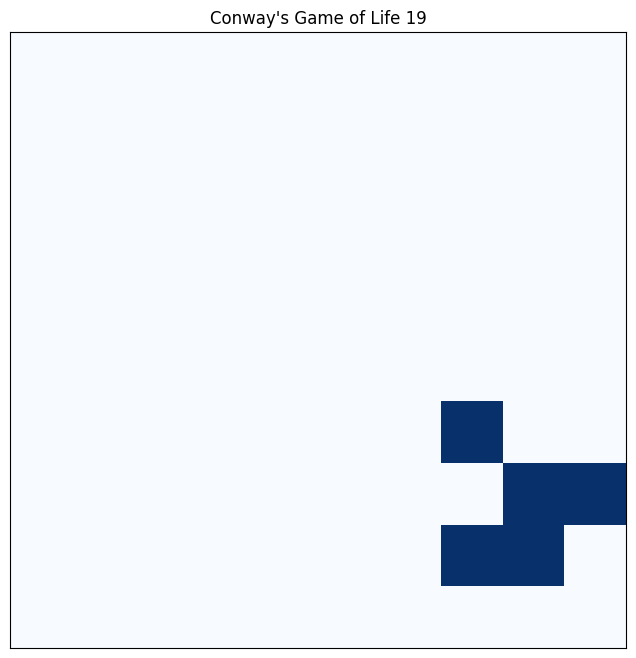

In [16]:
size = 10
life = Life2D(size)
glider = np.array([[0, 1, 0], [0, 0, 1], [1, 1, 1]], dtype=np.uint8)
life.state[1:4, 2:5] = glider             # bad idea to alter an objects state directly!  We'll improve it in Ex. 3
gol = Animation2D(life, frames=20)
gol.animate()

## Exercise 1:  Enumerate all Elementary 2D CA's
 * how many unique states are there for a 3x3 (9 cell) neighbourhood?
 * how many unique “rules” are there? (where a rule provides a mapping for each possible neighbourhood state to the output for the centre cell)
 * how does this number compare, for example, to the [number of atoms in the observable universe?](https://en.wikipedia.org/wiki/Observable_universe#Matter_content%E2%80%94number_of_atoms)
 * would it be a reasonable goal to conduct an experiment like Wolfram’s for 2D CA’s?
 * propose a numbering scheme for these rules, analogous to Wolfram’s rule numbers
 * how might we go about determining which rule number corresponds to Conway’s GoL?
   (I’m not asking for the number, but rather for a method you could use to find it.)

##Answers

1. For a 3 by 3 neighbourhood, there are 512 total unique states.
2. There are total of 2^512 that is 1.3*10^154 rules.
3. Total number of atoms in observable universe is approximately 10^80 but the result we got of rules is approximately the square of the number of atoms. This is a crazy number to imagine.
4. It can be reasonable to conduct such an experiment, but we need to have some reasonable rules to work with.
5. We can use counting here. Like if we have even numbers of 1's in neighbouring cells, we get a 1 and 0 otherwise or a specific numbering scheme from 0 to 8 such that with that many 1's only, we get a 1.



## Exercise 2: random_life
Extend the Life2D class defined above to allow the game to be initialized with a random start state.
The liklihood of any given cell being initialized to "alive" is given by $p$.
*Hint*: we did this exact exercise for a 1D array in lab 5

In [17]:

class BetterLife2D(Life2D):
    """ Improvements on the basic Life2D model """

    def __init__(self, rows, cols=None):
        super().__init__(rows, cols)

    def randomize_state(self, p):
        """ Randomize the state of this GoL, where probability of a "live" cell is p """
        random_array = np.random.rand(*self.state.shape)
        live_cells = random_array < p

        self.state = np.zeros(self.state.shape, dtype=np.uint8)
        self.state[live_cells] = 1


def random_better_life(n_rows, n_cols=None, p=0.5):
    """ Return a BetterLife2D object with initial randomized state where "live" cells have probability p """
    life = BetterLife2D(n_rows, n_cols)
    life.randomize_state(p)
    return life

foo = random_better_life(3)
print(foo.state)


[[1 0 1]
 [0 1 1]
 [1 1 1]]


### Experiment
Run a small experiment to see if you can identify any relationship between $p$, the probability of a live cell in the initial grid, and the time it takes for the GoL pattern to stabilize.

[0.0, 1.05, 1.975, 4.875, 13.897435897435898, 27.323529411764707, 51.54054054054054, 76.2, 84.96428571428571, 107.55555555555556, 99.3, 97.34615384615384, 110.54166666666667, 88.77272727272727, 118.19047619047619, 90.79166666666667, 105.5909090909091, 112.76, 111.125, 113.67857142857143, 114.91666666666667, 120.14814814814815, 123.56521739130434, 111.45, 87.90322580645162, 126.33333333333333, 110.85714285714286, 81.03703703703704, 100.45161290322581, 105.69565217391305, 80.24137931034483, 71.29629629629629, 89.62068965517241, 41.935483870967744, 42.696969696969695, 36.114285714285714, 15.432432432432432, 23.435897435897434, 8.275, 2.5641025641025643, 6.775, 4.825, 1.9, 1.5, 1.175, 1.125, 1.05, 1.0, 1.0, 1.0]


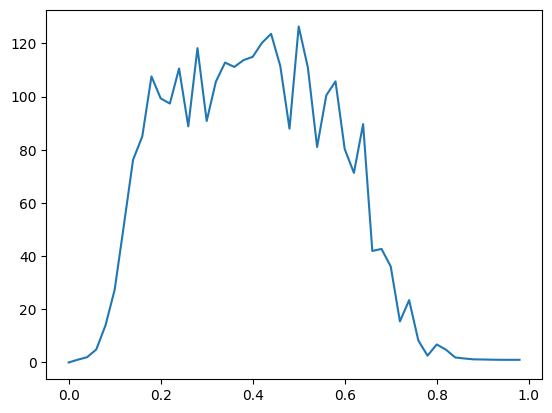

In [18]:
def find_stabilization_step(CA, max_step):
    # Returns the step at which the cellular automaton (CA) first stabilizes,
    # indicated by CA.state matching a previous state.

    states = []  # Stores previous states to check for stabilization
    for step in range(max_step):
        states.append(CA.state.copy())
        CA.step()
        for state in states:
            if np.array_equal(state, CA.state):
                return step
    return False  # if stabilization is not reached before max_step

results = []

for fifty_p in range(50):
    # Loop to simulate different probabilities (p) between 0 and 1
    trial_results = []

    for trial in range(40):
        # Perform 40 trials at each probability
        trial_results.append(find_stabilization_step(random_better_life(20, p=fifty_p/50), 200))

    # Calculate the mean stabilization step for this probability
    valid_results = [x for x in trial_results if x is not False]
    mean_step = np.mean(valid_results) if valid_results else 0
    results.append(mean_step)

print(results)

plt.plot([x/50 for x in range(50)], results)

## Exercise 3: Load Patterns
People have discovered many interesting ["patterns"](https://conwaylife.com/wiki/Category:Patterns) that exhibit various types of behaviours.
A "pattern" is just a small 2D array.
 1. Develop a function that returns a 2D array containing the patterns defined by a single string; and
 2. Add an `load_pattern(x, y, pattern)` method to your BetterLife2D class above to insert patterns into the Life state array
    *Tip*: you can [assign an entire 2D slice of a numpy array](https://www.nickmccullum.com/advanced-python/numpy-indexing-assignment/) in a single assignment statement!   See example in the Sample Usage block above. Try it!

In [19]:
glider_pattern = """
010
101
010
"""

def generate_pattern_array(glider_pattern):
    lines = glider_pattern.strip().split('\n')
    rows = len(lines)
    cols = max(len(line) for line in lines)

    pattern_array = np.zeros((rows, cols), dtype=np.uint8)

    for r, line in enumerate(lines):
        for c, char in enumerate(line):
            if char == '1':
                pattern_array[r, c] = 1

    return pattern_array

class BetterLife2D(Life2D):
    def __init__(self, rows, cols=None):
        super().__init__(rows, cols)

    def randomize_state(self, p):
        """ Randomize the state of this GoL, where probability of a "live" cell is p """
        random_array = np.random.rand(*self.state.shape)
        live_cells = random_array < p

        self.state = np.zeros(self.state.shape, dtype=np.uint8)
        self.state[live_cells] = 1

    def load_pattern(self, x, y, glider_pattern):
        pattern_array = generate_pattern_array(glider_pattern)

        rows, cols = pattern_array.shape
        x_end = min(x + rows, self.state.shape[0])
        y_end = min(y + cols, self.state.shape[1])

        self.state[x:x_end, y:y_end] = pattern_array[:x_end-x, :y_end-y]



life = BetterLife2D(10, 10)
life.load_pattern(2, 2, glider_pattern)

print(life.state)


[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 1 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


### Define some patterns
User your nifty new function to define a few common, interesting patterns (e.g., from the book or other sources)

In [24]:

spaceship = """
            00110
            11011
            11110
            01100 """ #Source- http://jakevdp.github.io/blog/2013/08/07/conways-game-of-life/


glider_pattern = spaceship

life = BetterLife2D(11, 11)
life.load_pattern(2, 2, glider_pattern)

print(life.state)

[[0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]]


In [25]:
boat = """
       110
       101
       010"""       #Source- http://jakevdp.github.io/blog/2013/08/07/conways-game-of-life/


glider_pattern = boat

life = BetterLife2D(11, 11)
life.load_pattern(2, 2, glider_pattern)

print(life.state)

[[0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]]


### Experiment
Load up a BetterLife2D object with some patterns that interact in some interesting way.
What can we learn from studying interactions like this?   Is anything here applicable to the real world?

In [21]:
# code for your experiment here